In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import dictys
from dictys.net import stat
import joblib
import pickle
from scipy.stats import median_abs_deviation, hypergeom
import math
from utils_custom import *

In [2]:
# Define file paths 
output_folder = '/ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_aggr/dictys_outs/actb1_added_v2/output/figures'
data_folder = '/ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_aggr/dictys_outs/actb1_added_v2/output'

In [3]:
dictys_dynamic_object = dictys.net.dynamic_network.from_file(os.path.join(data_folder, 'dynamic.h5'))

#### Load enriched link as per state

In [15]:
#Red = PB, Blue = GC
state_LF_file = '/ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_aggr/other_files/LF_enriched_TFs_static_GRN/gene_colors.csv'
enriched_links_file = '/ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_aggr/other_files/LF_enriched_TFs_static_GRN/SLIDE_LF_enrichment/SLIDE_LF_enriched_1_TFs_7_3_GC_PB.csv'
# store the state_LF in a df
state_LF = pd.read_csv(state_LF_file)
enriched_links = pd.read_csv(enriched_links_file)

In [5]:
def create_enriched_links_per_state(enriched_links, state_LF):
    # Create dictionaries to map genes to their states
    gene_to_state = dict(zip(state_LF['gene'], state_LF['color']))

    # Initialize lists to store links for each state
    state1_links = []  # For Red (PB)
    state2_links = []  # For Blue (GC)
    TFs = set()
    targets_in_lf = set()

    # Iterate over each row in the enriched_links DataFrame
    for _, row in enriched_links.iterrows():
        tf_str = row['TF']
        # Extract the TF name from the string representation of a tuple
        tf = tf_str.strip("(,)' ").replace("'", "")
        TFs.add(tf)
        
        # Handle the targets as a string representation of a list
        if isinstance(row['common'], str):
            # If it's a string representation of a list, convert it to a list
            targets_str = row['common'].strip("[]").replace("'", "")
            targets = [t.strip() for t in targets_str.split(",")]
        else:
            # If it's already a list
            targets = row['common']
    
        # Assign each TF-target pair to the appropriate state
        for target in targets:
            if target and target in gene_to_state:
                targets_in_lf.add(target)
                state = gene_to_state[target]
                link = (tf, target)
                if state == 'Red':
                    state1_links.append(link)
                elif state == 'Blue':
                    state2_links.append(link)
    TFs = list(TFs)
    targets_in_lf = list(targets_in_lf)

    return state1_links, state2_links, TFs, targets_in_lf

In [6]:
PB_links, GC_links, TFs, targets_in_lf = create_enriched_links_per_state(enriched_links, state_LF)

In [19]:
# filter the TFs that are not in the dynamic object
TF_indices, _, missing_tfs = get_tf_indices(dictys_dynamic_object, TFs)
# Remove items that are not in the dynamic object
filtered_TFs = [item for item in TFs if item not in missing_tfs]

#update the GC_links and PB_links
GC_links = [link for link in GC_links if link[0] in filtered_TFs]
PB_links = [link for link in PB_links if link[0] in filtered_TFs]


#### Load the network and get force values

In [32]:
pts, fsmooth = dictys_dynamic_object.linspace(0,3,100,0.0005)
stat1_net = fsmooth(stat.net(dictys_dynamic_object,varname='w_in')) #varname='w_in' total effect network
stat1_netbin = stat.fbinarize(stat1_net,sparsity=0.01)
stat1_x=stat.pseudotime(dictys_dynamic_object,pts)
dtime = pd.Series(stat1_x.compute(pts)[0])

In [33]:
dnetbin = stat1_netbin.compute(pts)
display(dnetbin.shape)

(551, 11907, 100)

In [35]:
# compute the weighted network
dnet = stat1_net.compute(pts)
display(dnet.shape)

(551, 11907, 100)

In [36]:
# get target indices 
lf_genes_indices = get_gene_indices(dictys_dynamic_object, targets_in_lf)

In [37]:
# Get the subnetworks for the enriched TFs
filtered_subnetworks = dnet[np.ix_(TF_indices, lf_genes_indices, range(dnet.shape[2]))]
display(filtered_subnetworks.shape)

(13, 35, 100)

In [38]:
# Create multi-index tuples (all combinations of TF-target pairs)
index_tuples = [(tf, target) for tf in filtered_TFs for target in targets_in_lf]
multi_index = pd.MultiIndex.from_tuples(index_tuples, names=['TF', 'Target'])
# Reshape the subnetworks array to 2D (pairs × time points)
n_tfs, n_targets, n_times = filtered_subnetworks.shape
reshaped_data = filtered_subnetworks.reshape(-1, n_times)

# Create DataFrame with multi-index
lf_beta_dcurve = pd.DataFrame(
    reshaped_data,
    index=multi_index,
    columns=[f'time_{i}' for i in range(n_times)]
)
enriched_betas = lf_beta_dcurve.loc[GC_links]
print(enriched_betas.shape)

(10, 100)


In [39]:
lcpm_dcurve, dtime = compute_expression_regulation_curves(dictys_dynamic_object, start=0, stop=3, num=100, dist=0.0005, mode="expression")

In [40]:
# get the tf_lcpms for the lineage
tf_list = enriched_betas.index.get_level_values('TF').unique().tolist()
enriched_tfs_lcpm_dcurve = lcpm_dcurve.loc[tf_list]
print(len(enriched_tfs_lcpm_dcurve))

7


In [41]:
lf_forces_dcurve = calculate_force_curves(enriched_betas, enriched_tfs_lcpm_dcurve)
display(lf_forces_dcurve.head())
display(lf_forces_dcurve.shape)

time_0    time_1    time_2    time_3    time_4    time_5  \
TF      Target                                                                
IRF4    AFF3    -0.124460 -0.117139 -0.108919 -0.099533 -0.088523 -0.074991   
CREB3L2 PIKFYVE -0.245357 -0.243677 -0.241826 -0.239799 -0.237588 -0.235184   
        PAX5    -0.200923 -0.204978 -0.208698 -0.212098 -0.215191 -0.217983   
PAX5    MED23   -0.132878 -0.135844 -0.138701 -0.141448 -0.144082 -0.146599   
        AFF3    -0.089439 -0.088348 -0.087255 -0.086172 -0.085117 -0.084109   

                   time_6    time_7    time_8    time_9  ...   time_90  \
TF      Target                                           ...             
IRF4    AFF3    -0.056629 -0.017815  0.053623  0.074073  ...  0.200524   
CREB3L2 PIKFYVE -0.232578 -0.229758 -0.226711 -0.223419  ...  0.227277   
        PAX5    -0.220480 -0.222682 -0.224585 -0.226185  ... -0.307298   
PAX5    MED23   -0.148996 -0.151267 -0.153407 -0.155409  ... -0.150198   
        AFF3    -0.083169 -0.082324 -0.081601 -0.081035  ... -0.261763   

                  time_91   time_92   time_93   time_94   time_95   time_96  \
TF      Target                                                                
IRF4    AFF3     0.198302  0.196084  0.193870  0.191658  0.189449  0.187243   
CREB3L2 PIKFYVE  0.228994  0.230735  0.232497  0.234277  0.236074  0.237885   
        PAX5    -0.308869 -0.310398 -0.311889 -0.313342 -0.314760 -0.316143   
PAX5    MED23   -0.150118 -0.150041 -0.149968 -0.149900 -0.149837 -0.149781   
        AFF3    -0.262676 -0.263569 -0.264445 -0.265304 -0.266147 -0.266976   

                  time_97   time_98   time_99  
TF      Target                                 
IRF4    AFF3     0.185038  0.182834  0.180631  
CREB3L2 PIKFYVE  0.239709  0.241545  0.243390  
        PAX5    -0.317493 -0.318812 -0.320101  
PAX5    MED23   -0.149731 -0.149688 -0.149653  
        AFF3    -0.267790 -0.268591 -0.269380  

[5 rows x 100 columns]

(10, 100)

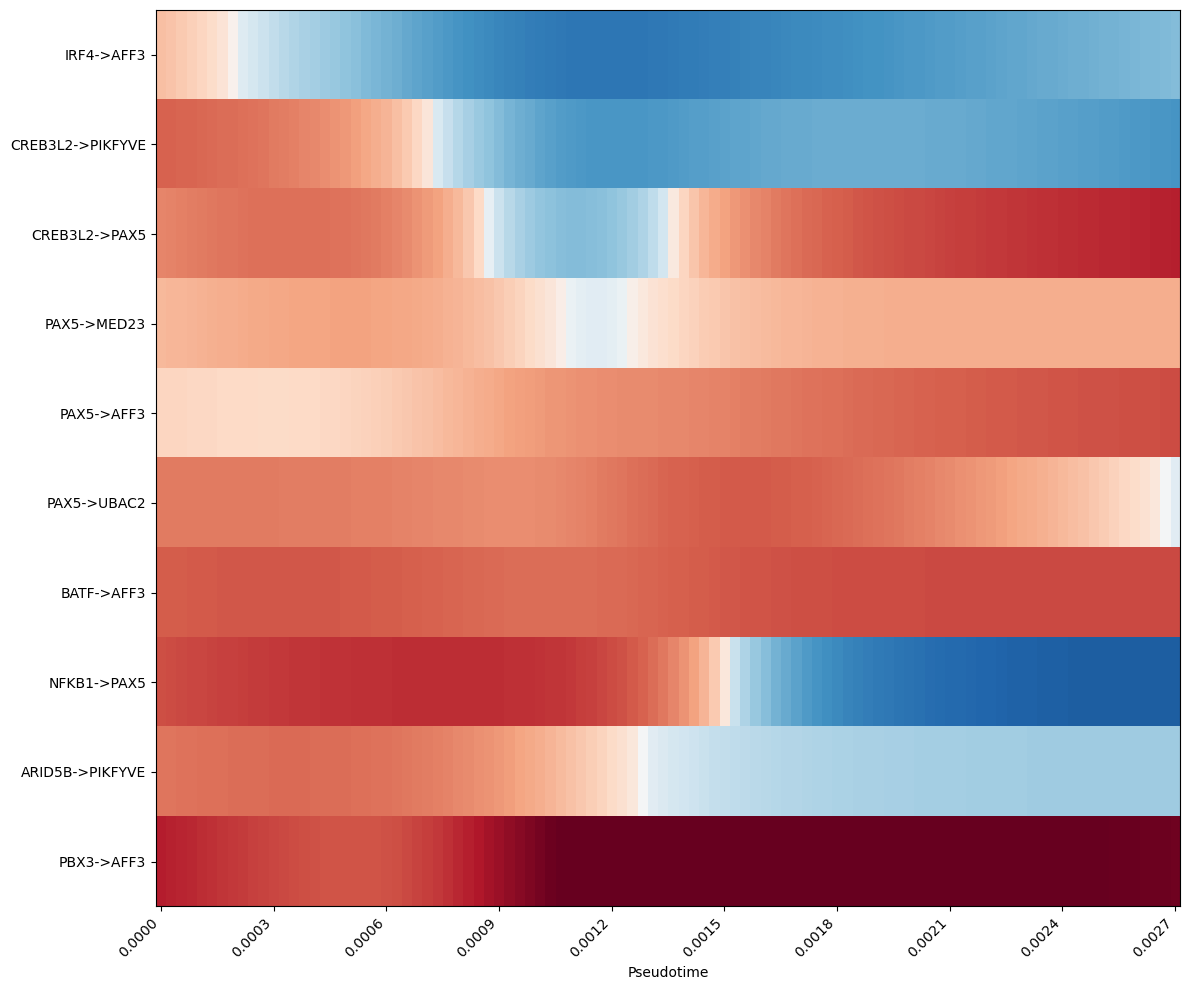

In [42]:
fig, ax, force_values = plot_force_heatmap(
    force_df=lf_forces_dcurve,
    dtime=dtime,
    regulations=GC_links,
    figsize=(12, 10),
    cmap='RdBu'
)